Let's examine discrete PCA. See how quickly eigenvalues decay, directions of greatest variance, association between these and the response, etc.

Let's build discrete PCA from scratch.

## Imports

In [1]:
from pathlib import Path
import statistics

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from tqdm import tqdm

from tecatorfda.data import load_tecator_fat
from tecatorfda.pca_models import CustomPCA

## Load the data

In [2]:
# Define the data directory to save to.
project_root = Path.cwd().resolve().parent.parent
output_directory = project_root / "artifacts" / "original_data" / "08_pca"

# Define the data directory to read from.
data_location_directory = project_root / "data" / "original"
artifacts_location_directory = project_root / "artifacts" / "original_data"

# Load the data.
tecator_df, fat_df, wavelength_grid, wavelength_unit = load_tecator_fat(
    location=data_location_directory
)

X = tecator_df.to_numpy()
y = fat_df.to_numpy().ravel()

## Discrete PCA

There are two PCA procedures, equivalent in theory but not in bad computation scenarios. The first is to construct the covariance matrix $\frac{1}{n-1}(X-\mu)'(X-\mu)$, then perform an eigenanalysis of it, often through SVD. The singular values directly correspond to explained variance proportions.

The second method, and the one that *scikit-learn* actually uses, is to instead perform SVD on the centered data matrix $X-\mu$, and then square the singular values and divide by $n-1$. This avoids multiplying a matrix against its transpose, which could cause numerical instabilities.

In [3]:
customPCA = CustomPCA()
customPCA.fit(X)
Xt = customPCA.transform(X)
eigenvalues = customPCA.explained_variance_

In [4]:
print(eigenvalues)

[2.61271328e+01 2.38536854e-01 7.84488339e-02 3.01850127e-02
 1.52348228e-03 6.66163525e-04 2.05221192e-04 1.08421280e-04
 2.07732646e-05 1.15035938e-05 4.18857510e-06 2.98457121e-06
 9.80885356e-07 5.20434956e-07 2.57024753e-07 2.01078837e-07
 1.55801973e-07 1.34122631e-07 8.76867454e-08 6.23114823e-08
 4.02052899e-08 3.21086054e-08 2.79564675e-08 2.02328514e-08
 1.93605664e-08 1.23194449e-08 1.10311660e-08 9.42072471e-09
 8.40555398e-09 7.40375017e-09 6.15319379e-09 6.08320767e-09
 5.16991561e-09 4.52663787e-09 3.80267127e-09 2.83169571e-09
 2.74145264e-09 2.59372980e-09 2.19637465e-09 1.90474653e-09
 1.75864172e-09 1.33221651e-09 1.29246382e-09 1.27239918e-09
 1.17748939e-09 9.92726836e-10 8.02350049e-10 7.56271039e-10
 6.73383648e-10 6.16732191e-10 5.48204186e-10 4.95193063e-10
 4.32649372e-10 3.70253815e-10 3.44974246e-10 3.22774564e-10
 2.95225614e-10 2.80800712e-10 2.61027988e-10 2.42307297e-10
 2.35582761e-10 2.23199920e-10 2.14909973e-10 1.86292157e-10
 1.71126831e-10 1.440286

## Analyze the eigenvalues

In [5]:
# Display eigenvalues of correlation matrix table.
table_1 = pd.DataFrame (columns =["Eigenvalue", "Difference", "Proportion", "Cumulative"])
table_1["Eigenvalue"] = eigenvalues
table_1["Difference"] = np.concatenate([eigenvalues[:-1] - eigenvalues[1:], [np.nan]])
proportions = eigenvalues / eigenvalues.sum()
table_1["Proportion"] = proportions
table_1["Cumulative"] = np.cumsum(proportions)
table_1.head().style.set_table_attributes("style=display:inline").set_caption("Eigenvalues of covariance matrix").format("{:.2f}")

,Eigenvalue,Difference,Proportion,Cumulative
0,26.13,25.89,0.99,0.99
1,0.24,0.16,0.01,1.00
2,0.08,0.05,0.00,1.00
3,0.03,0.03,0.00,1.00
4,0.00,0.00,0.00,1.00


Scree and proportion plots.

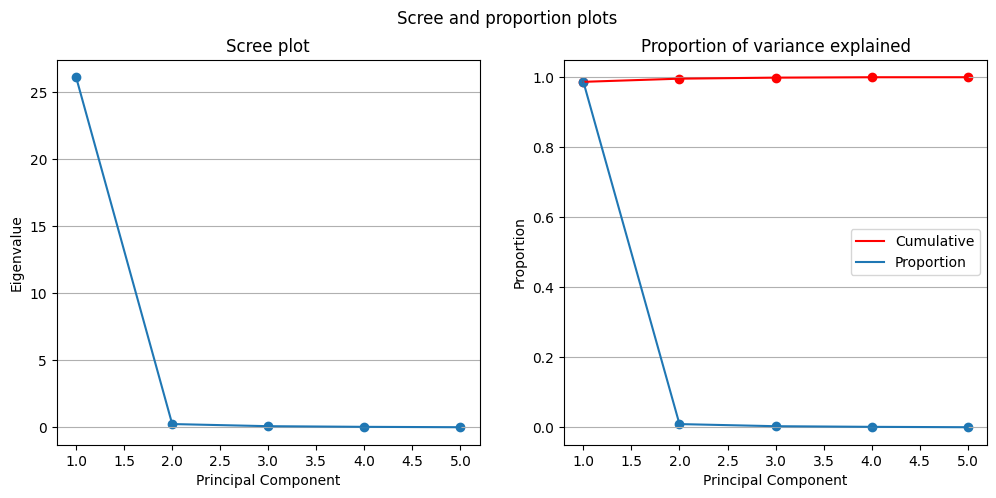

In [6]:
n_comps = 5
eigs = eigenvalues[:n_comps]
props = proportions[:n_comps]

fig, ax = plt.subplots(1, 2, figsize=(12,5))

fig.suptitle('Scree and proportion plots')

ax[0].set_title('Scree plot')
ax[0].set_xlabel('Principal Component')
ax[0].set_ylabel('Eigenvalue')
ax[0].grid(axis='y')
ax[0].plot(list(range(1, n_comps+1)), eigs)
ax[0].scatter(list(range(1, n_comps+1)), eigs)

ax[1].set_title('Proportion of variance explained')
ax[1].set_xlabel('Principal Component')
ax[1].set_ylabel('Proportion')
ax[1].grid(axis='y')
ax[1].plot(list(range(1, n_comps+1)), np.cumsum(props), label='Cumulative', c='red')
ax[1].scatter(list(range(1, n_comps+1)), np.cumsum(props), c='red')
ax[1].plot(list(range(1, n_comps+1)), props, label='Proportion')
ax[1].scatter(list(range(1, n_comps+1)), props)
ax[1].legend()

plt.show()

## Analyze the eigenvectors

Plot the principal components over time.

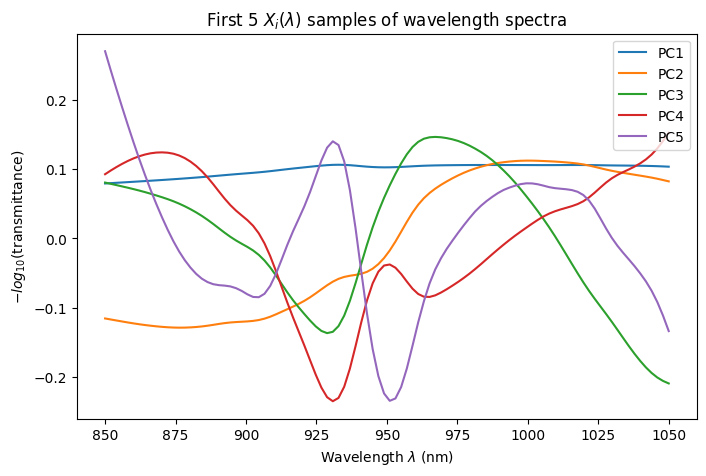

In [11]:
plt.figure(figsize=(8,5))

for i in range(5):
    plt.plot(wavelength_grid, customPCA.components_[i], label=f"PC{i+1}")

# plt.plot(wavelength_grid, tecator_df.mean(axis=0), linestyle="--", c="black", label=r"Mean functional $\mu(\lambda)$")

plt.title(r"First 5 $X_{i}(\lambda)$ samples of wavelength spectra")
plt.xlabel(rf"Wavelength $\lambda$ ({wavelength_unit})")
plt.ylabel(r"$-log_{10}(\text{transmittance})$")
plt.legend()
plt.show()

Plot the mean functional plus and minus the first few principal components, individually.

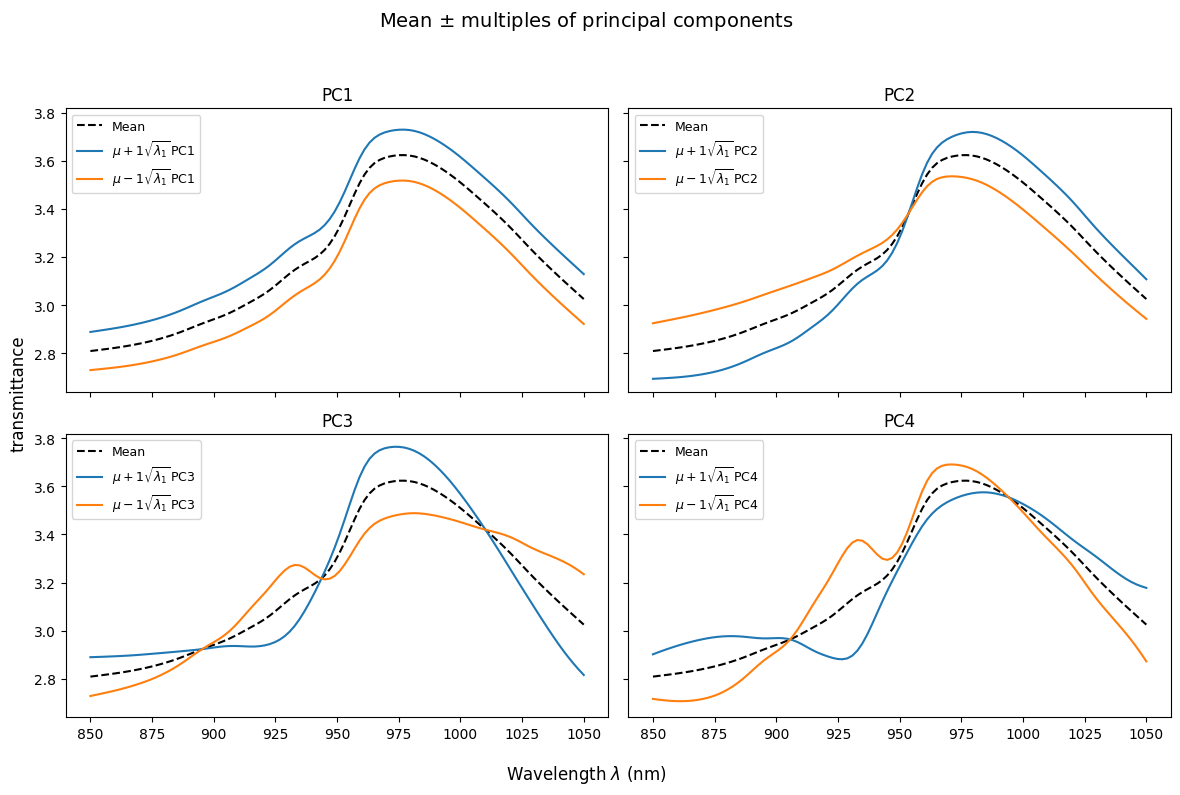

In [29]:
mean_func = X.mean(axis=0)

c = 1 # Multiple to use

fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
ax = ax.flatten()

for i in range(4):
    # Shorthand for the current principal component.
    pc = customPCA.components_[i]

    # Standard deviation.
    sd = np.sqrt(customPCA.explained_variance_[i])

    # Plots.
    ax[i].plot(wavelength_grid, mean_func,
            color="black", linestyle="--", label="Mean")
    ax[i].plot(
        wavelength_grid,
        mean_func + c * customPCA.components_[i],
        label=rf"$\mu + {c}\sqrt{{\lambda_1}}\,\mathrm{{PC{i+1}}}$"
    )
    ax[i].plot(
        wavelength_grid,
        mean_func - c * customPCA.components_[i],
        label=rf"$\mu - {c}\sqrt{{\lambda_1}}\,\mathrm{{PC{i+1}}}$"
    )

    ax[i].set_title(rf"PC{i+1}")
    ax[i].legend(fontsize=9)

fig.suptitle(r"Mean $\pm$ multiples of principal components", fontsize=14)
fig.supxlabel(rf"Wavelength $\lambda$ ({wavelength_unit})")
fig.supylabel("transmittance")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Plot scores colored by $y$

Compute them.

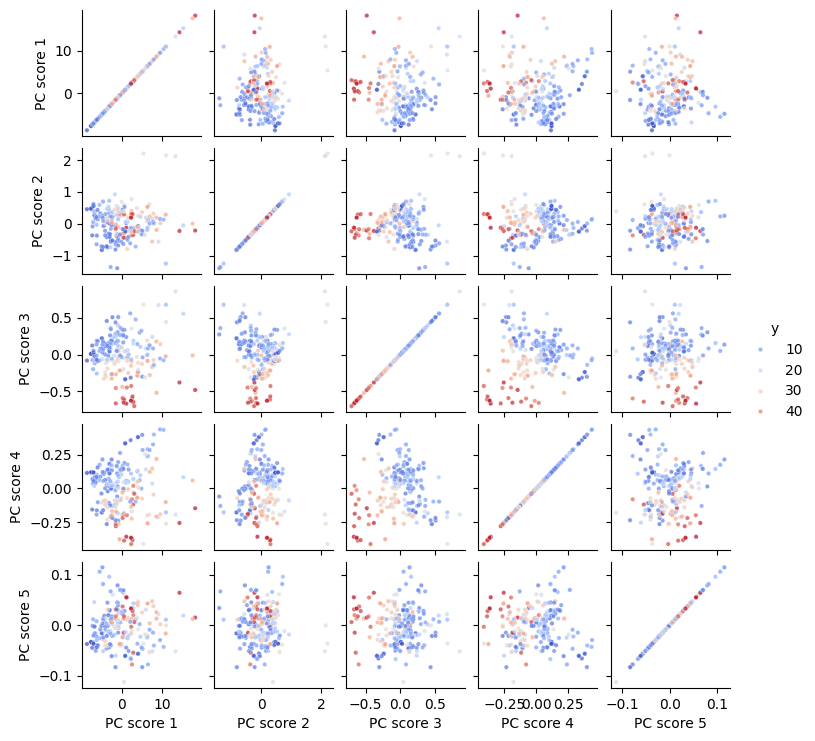

In [7]:
df = pd.DataFrame(
    Xt[:, :n_comps],
    columns=[f'PC score {i}' for i in range(1, n_comps + 1)]
)
df["y"] = y

sns.pairplot(
    df,
    hue="y",
    height=1.5,
    aspect=1.,
    plot_kws={"alpha": 0.7, "s": 10},
    palette="coolwarm",
    diag_kind=None,
    )

plt.show()

Plot correlations between scores and $y$.

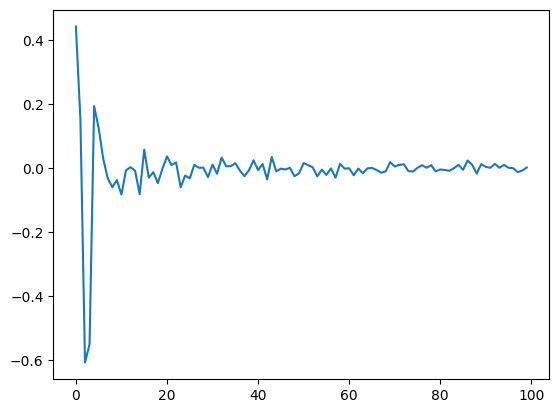

In [8]:
plt.plot(np.arange(100), np.corrcoef(np.concat((Xt.T, y.reshape(1,-1)), axis=0))[-1,:100])

## Principal components regression

In [9]:
# Define a principal components regression pipeline. Very customizable.
pcr = Pipeline(
    steps=[
        ("pca", CustomPCA()),
        ("lr", LinearRegression()),
    ]
)

# Define a small grid to search over.
param_grid = {
    "pca__n_components": [1,2,3,5,10,20,30,40,50,60,80,100],
}

# Inner CV: performed once.
inner_cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=0)

# Outer CV: performed 10 times.
outer_cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0)

# Specify the grid search.
gs = GridSearchCV(
    pcr, param_grid=param_grid, cv=inner_cv, scoring="r2", n_jobs=-1
)

# Compute R^2 scores manually with a progress bar.
scores = []
selected_n_comps = []
for fold, (train_idx, test_idx) in enumerate(tqdm(outer_cv.split(X), total=100)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    gs.fit(X_train, y_train)
    y_pred = gs.best_estimator_.predict(X_test)

    scores.append(r2_score(y_test, y_pred))
    selected_n_comps.append(gs.best_params_["pca__n_components"])
scores = np.array(scores)

print()
print("CV R^2 median:", round(statistics.median(scores), 4))
print("CV R^2 mean:", round(scores.mean(), 4))
print("CV R^2 standard deviation:", round(scores.std(), 4))

100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


CV R^2 median: 0.9587
CV R^2 mean: 0.9465
CV R^2 standard deviation: 0.0481


What do the best n_comps look like? I think this plot is super informative. The splits where 60 components perform best are much, much worse than all the others, but these may be splits where outliers are present in the holdout set.

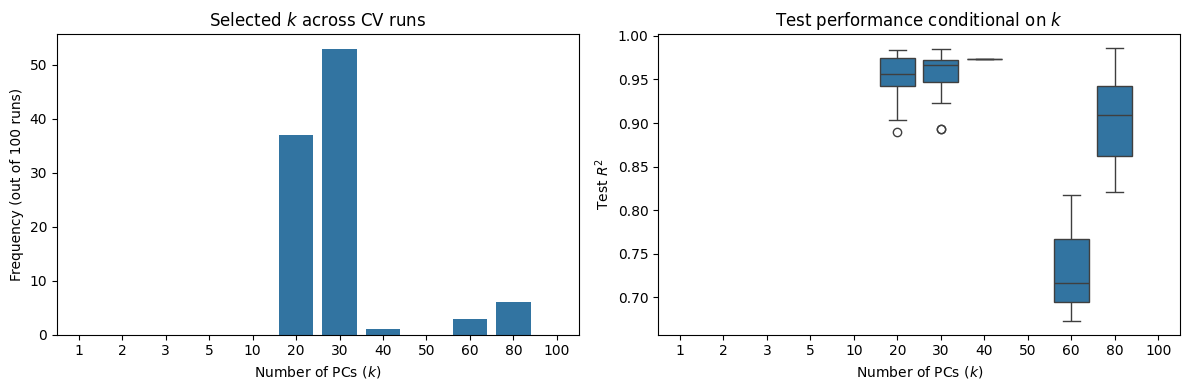

In [10]:
# Assemble once
df = pd.DataFrame({
    "k": selected_n_comps,
    "r2": scores,
})

order = sorted(param_grid["pca__n_components"])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

# --- Left: distribution of selected k ---
sns.countplot(
    x="k",
    data=df,
    order=order,
    ax=axes[0]
)
axes[0].set_xlabel("Number of PCs ($k$)")
axes[0].set_ylabel("Frequency (out of 100 runs)")
axes[0].set_title("Selected $k$ across CV runs")

# --- Right: test R² by selected k ---
sns.boxplot(
    x="k",
    y="r2",
    data=df,
    order=order,
    ax=axes[1]
)
axes[1].set_xlabel("Number of PCs ($k$)")
axes[1].set_ylabel(r"Test $R^{2}$")
axes[1].set_title("Test performance conditional on $k$")

plt.tight_layout()
plt.show()